## **1. Setup**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## **2. Load Data**

In [ ]:
train_df = pd.read_csv("train_df.csv")
val_df = pd.read_csv("val_df.csv")
test_df = pd.read_csv("test_df.csv")

## **3. Machine Learning**

### **3.1 K-Nearest Neighbors**

The k-NN algorithm is the most simple algorithm, which requires only a train set to vuild the model and makes prediction on the query sample based on the closet point in the training set.

The problem that we are working on is of classification. Let's get an intuitive idea about the core of this method.

#### **3.1.1 Visualizing K-NN Algorithm**

In [ ]:
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def scale(X):
    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    return X_std

def plot_knn_classification(ax, n_neighbors=1):
    X = train_df.iloc[:50, [1,5]].to_numpy()
    y = train_df.iloc[:50, -1].to_numpy()

    df = val_df.loc[val_df.target==0].reset_index(drop=True)
    X_query = df.iloc[:3, [1,5]].to_numpy()

    X = scale(X)
    X_query = scale(X_query)

    dist = euclidean_distances(X, X_query)
    closest = np.argsort(dist, axis=0)

    c0 = 0
    c1 = 0
    c2 = 0

    for x, y in zip(X,y):
      if y==0:
        if c0==0:
          ax.scatter(x[0], x[1], c='b', label='class 0')
          c0+=1
        else:
          ax.scatter(x[0], x[1], c='b')
      elif y==1:
        if c1==0:
          ax.scatter(x[0], x[1], c='g', label='class 1')
          c1+=1
        else:
          ax.scatter(x[0], x[1], c='g')
      else:
        if c2==0:
          ax.scatter(x[0], x[1], c='pink', label='class 2')
          c2+=1
        else:
          ax.scatter(x[0], x[1], c='pink')

    lst = ['y', 'cyan', 'gray']
    ct = 0
    for x, neighbors in zip(X_query, closest.T):
        if ct==0:
          ax.scatter(x[0], x[1], c='red', marker='D', label='test class 0')
        else:
          ax.scatter(x[0], x[1], c='red', marker='D')
        for neighbor in neighbors[:n_neighbors]:
            ax.arrow(x[0], x[1], X[neighbor, 0] - x[0],
                      X[neighbor, 1] - x[1], head_width=0, fc=lst[ct], ec=lst[ct])
        ct+=1
    ax.legend()
    ax.set_xlabel('Scaled Variance')
    ax.set_ylabel('Scaled Kurtosis')
    ax.set_title('{} Nearest Neighbors'.format(n_neighbors))

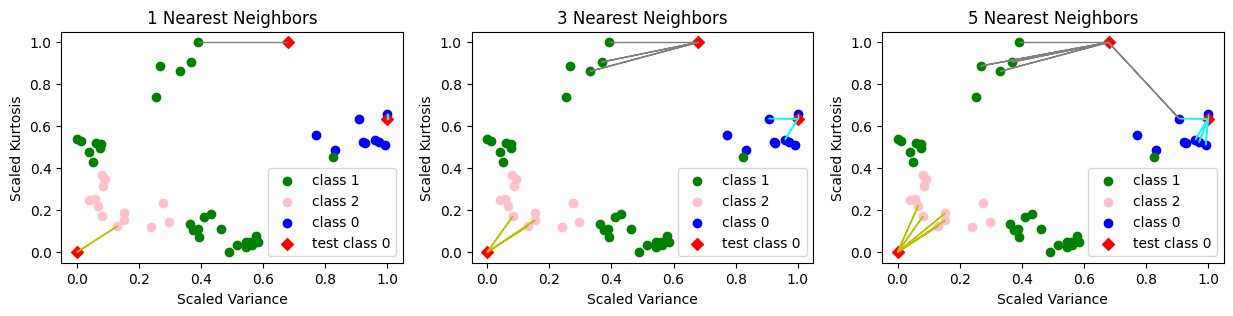

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
plot_knn_classification(axes[0], 1)
plot_knn_classification(axes[1], 3)
plot_knn_classification(axes[2], 5)


#### **3.1.2 Developing K-NN Models**

In [ ]:
X_train, y_train = train_df.iloc[:, [1,5]].to_numpy(), train_df.iloc[:,-1].to_numpy()
X_val, y_val = val_df.iloc[:, [1,5]].to_numpy(), val_df.iloc[:,-1].to_numpy()
X_test, y_test = test_df.iloc[:, [1,5]].to_numpy(), test_df.iloc[:,-1].to_numpy()


In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
clf = KNeighborsClassifier(n_neighbors=3)


In [ ]:
clf.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
print("Train set accuracy: {:.2f}".format(clf.score(X_train_scaled, y_train)))
print("Validation set accuracy: {:.2f}".format(clf.score(X_val_scaled, y_val)))
print("Test set accuracy: {:.2f}".format(clf.score(X_test_scaled, y_test)))

Train set accuracy: 0.98
Validation set accuracy: 0.97
Test set accuracy: 0.97


#### **3.1.3 Analyzing K-NN**

In [ ]:
def plot_decisions_multiple(clf, X, y_train, ax, n, title, scat = False):

    min1, max1 = X[:, 0].min()-0.1, X[:, 0].max()+0.1
    min2, max2 = X[:, 1].min()-0.1, X[:, 1].max()+0.1

    xgrid = np.arange(min1, max1, 0.05)
    ygrid = np.arange(min2, max2, 0.05)

    xx, yy = np.meshgrid(xgrid, ygrid)

    # Creating features
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    grid = np.hstack((r1,r2))

    yhat = clf.predict(grid)
    zz = yhat.reshape(xx.shape)

    ax.contourf(xx, yy, zz, alpha=0.5, cmap='Set3')

    if scat == True:
      clr = ['b', 'orange', 'g']
      for class_value in range(3):
          # get row indexes for samples with this class
          row_ix = np.where(y_train == class_value)
          # create scatter of these samples
          ax.scatter(X[row_ix, 0], X[row_ix, 1], c=clr[class_value],
                     alpha=0.5, label='class {}'.format(class_value))
          ax.set_title(title)
          ax.set_xlabel('Variance')
      ax.legend()
    else:
        ax.set_xlabel('Variance')
        ax.set_title(title)

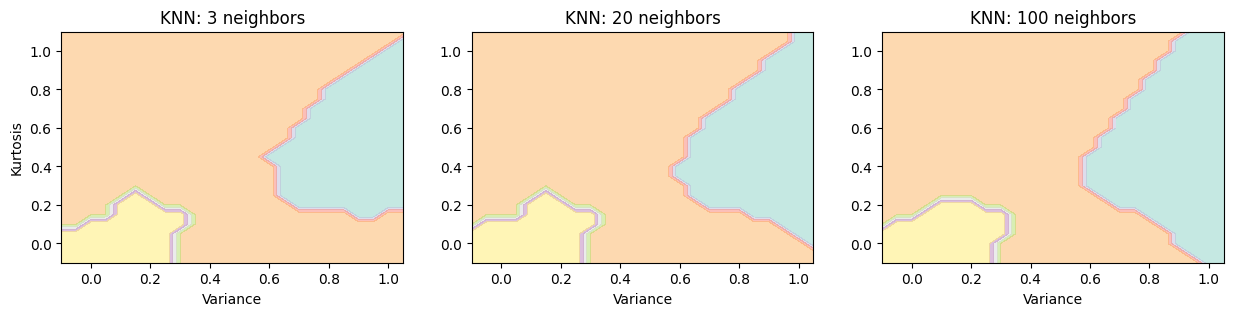

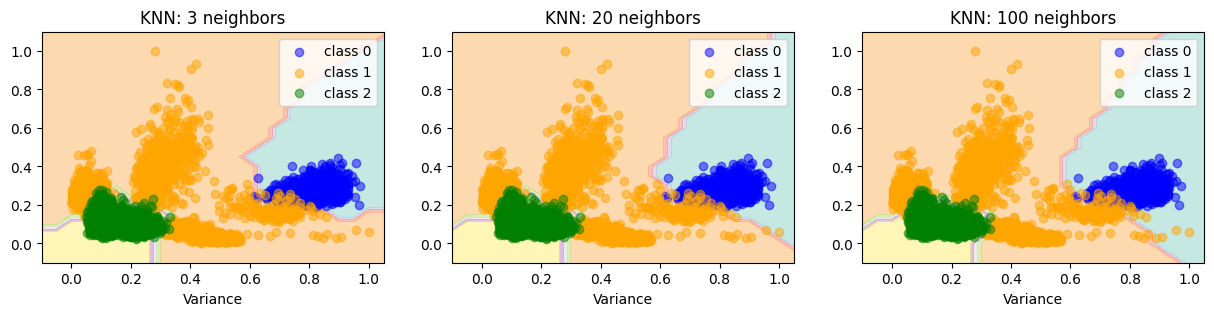

In [ ]:
ct = 0
cm, cm_v, cm_t = [], [], []
ns = [3, 20, 100]

fig, axes = plt.subplots(1, 3, figsize=(15, 3))
for n, ax in zip(ns, axes):
    clf = KNeighborsClassifier(n_neighbors=n).fit(X_train_scaled, y_train)
    plot_decisions_multiple(clf, X_train_scaled, y_train, ax, n, 'KNN: {} neighbors'.format(n))
    if ct==0:
        ct += 1
        ax.set_ylabel('Kurtosis')
    cm.append(confusion_matrix(y_train, clf.predict(X_train_scaled), labels=clf.classes_))
    cm_v.append(confusion_matrix(y_val, clf.predict(X_val_scaled), labels=clf.classes_))
    cm_t.append(confusion_matrix(y_test, clf.predict(X_test_scaled), labels=clf.classes_))


fig1, axes1 = plt.subplots(1, 3, figsize=(15, 3))
for n, ax in zip(ns, axes1):
    clf = KNeighborsClassifier(n_neighbors=n).fit(X_train_scaled, y_train)
    plot_decisions_multiple(clf, X_train_scaled, y_train, ax, n, 'KNN: {} neighbors'.format(n), True)
    if ct==0:
        ct += 1
        ax.set_ylabel('Kurtosis')


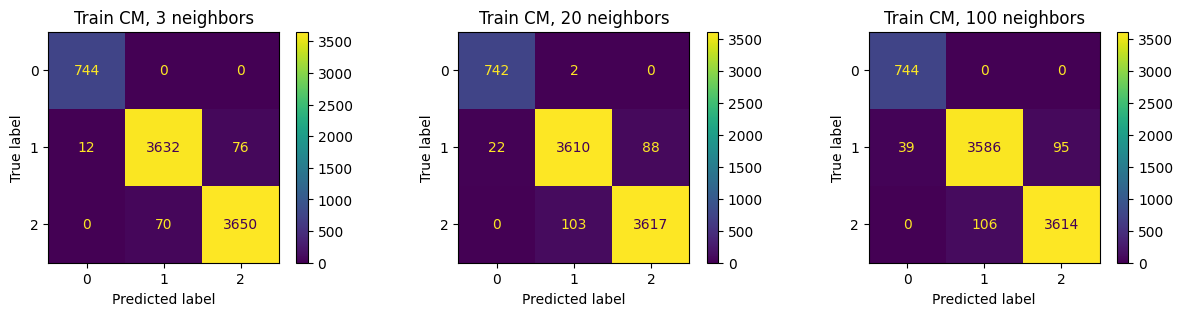

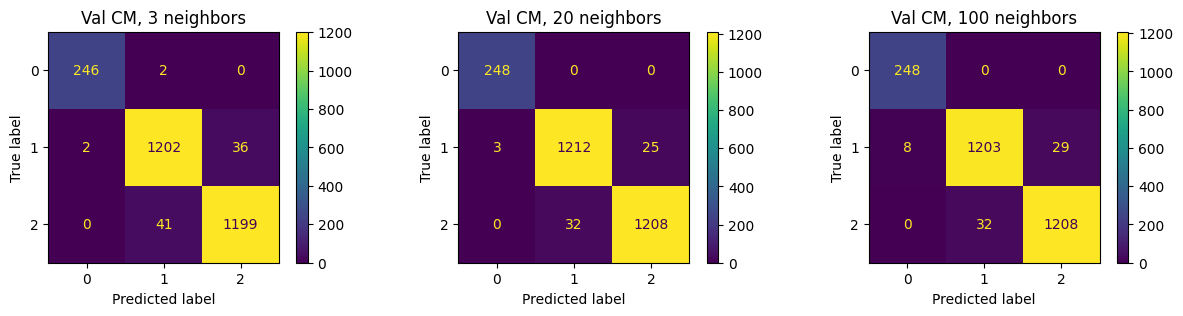

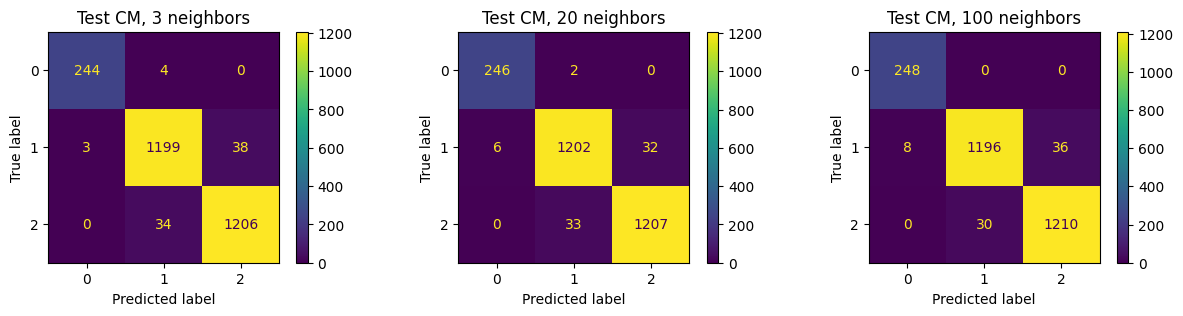

In [ ]:

fig2, axes2 = plt.subplots(1, 3, figsize=(15, 3))
for i in range(len(axes2)):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm[i])
    disp.plot(ax=axes2[i])
    axes2[i].set_title('Train CM, {} neighbors'.format(ns[i]))

fig3, axes3 = plt.subplots(1, 3, figsize=(15, 3))
for i in range(len(axes2)):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_v[i])
    disp.plot(ax=axes3[i])
    axes3[i].set_title('Val CM, {} neighbors'.format(ns[i]))

fig4, axes4 = plt.subplots(1, 3, figsize=(15, 3))
for i in range(len(axes2)):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_t[i])
    disp.plot(ax=axes4[i])
    axes4[i].set_title('Test CM, {} neighbors'.format(ns[i]))


#### **3.1.4 Strengths and Weakness of K-NN**

**Parameters:**
There are two main parameters of the K-NN model. N-Nearest Neighbors and the method used to calculate the distance between points. These parameters can be explored to analyze how the model performs.


**Strengths:**
1. Easy to understand
2. Ususally fast
3. Can build non-linear decision boundaries

**Weakness:**
1. The model fails to work effectively when the number of dimensions increase.
2. Also, this model doesn't work well with sparse datasets.


### **3.2 Linear Models**

Linear models are very effective even with higher dimensions. But, most models are built for binary classification. To perform multi-class classification with linear models, we need to use one-ve-rest approach. Different models are learned for each class. To get the final label, the class that has the highest score is selected.

#### **3.2.1 Linear SVC**


In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
linear_svm = LinearSVC().fit(X_train_scaled, y_train)
print("Coefficient shape: ", linear_svm.coef_.shape)
print("Intercept shape: ", linear_svm.intercept_.shape)

Coefficient shape:  (3, 2)
Intercept shape:  (3,)


In [ ]:
print("Train set accuracy: {:.2f}".format(linear_svm.score(X_train_scaled, y_train)))
print("Validation set accuracy: {:.2f}".format(linear_svm.score(X_val_scaled, y_val)))
print("Test set accuracy: {:.2f}".format(linear_svm.score(X_test_scaled, y_test)))

Train set accuracy: 0.88
Validation set accuracy: 0.89
Test set accuracy: 0.88


#### **3.2.2 Visualizing SVM Algorithm**

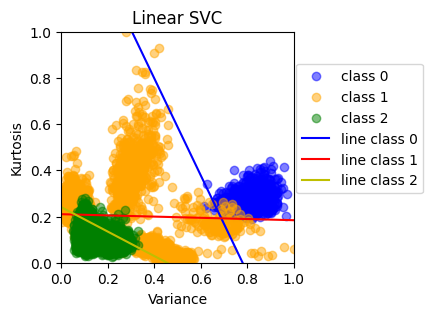

In [ ]:
line = np.linspace(0, 1)
fig = plt.figure(figsize=(3,3))
ct = 0

clr = ['b', 'orange', 'g']
for class_value in range(3):
    # get row indexes for samples with this class
    row_ix = np.where(y_train == class_value)
    # create scatter of these samples
    plt.scatter(X_train_scaled[row_ix, 0], X_train_scaled[row_ix, 1], c=clr[class_value],
                alpha=0.5, label='class {}'.format(class_value))
    plt.title('Linear SVC')
    plt.xlabel('Variance')
    plt.ylabel('Kurtosis')


for coef, intercept, color in zip(linear_svm.coef_,
                                  linear_svm.intercept_,
                                   ['b', 'r', 'y']):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1], c=color, label='line class {}'.format(ct))
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    ct += 1
plt.legend(loc=(1.01, 0.3))
plt.show()

#### **3.2.3 Analyzing SVC**

In [ ]:
def plot_decisions(clf, X, y_train, ax, name, scat = False):

    min1, max1 = X[:, 0].min()-0.1, X[:, 0].max()+0.1
    min2, max2 = X[:, 1].min()-0.1, X[:, 1].max()+0.1

    xgrid = np.arange(min1, max1, 0.05)
    ygrid = np.arange(min2, max2, 0.05)

    xx, yy = np.meshgrid(xgrid, ygrid)

    # Creating features
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    grid = np.hstack((r1,r2))

    yhat = clf.predict(grid)
    zz = yhat.reshape(xx.shape)

    ax.contourf(xx, yy, zz, alpha=0.5, cmap='Set3')

    if scat == True:
      clr = ['b', 'orange', 'g']
      for class_value in range(3):
          # get row indexes for samples with this class
          row_ix = np.where(y_train == class_value)
          # create scatter of these samples
          ax.scatter(X[row_ix, 0], X[row_ix, 1], c=clr[class_value],
                     alpha=0.5, label='class {}'.format(class_value))
          ax.set_title('{} Decision boundary'.format(name))
          ax.set_xlabel('Variance')
      ax.legend()
    else:
        ax.set_xlabel('Variance')
        ax.set_title('{} Decision boundary'.format(name))

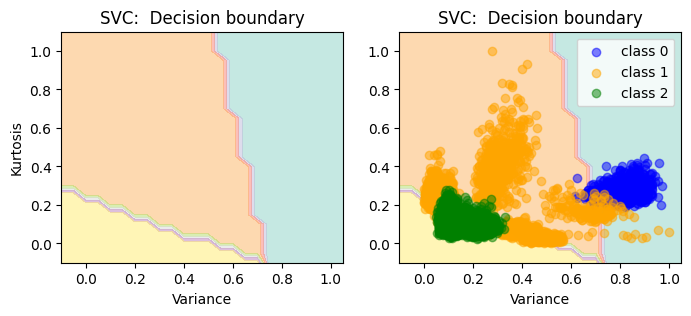

In [ ]:
ct = 0
cm, cm_v, cm_t = [], [], []
check = [0, 1]
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
for ax, i in zip(axes, check):
    if i==0:
        plot_decisions(linear_svm, X_train_scaled, y_train, ax, 'SVC: ')
    else:
        plot_decisions(linear_svm, X_train_scaled, y_train, ax, 'SVC: ', True)
    if ct==0:
        ct += 1
        ax.set_ylabel('Kurtosis')

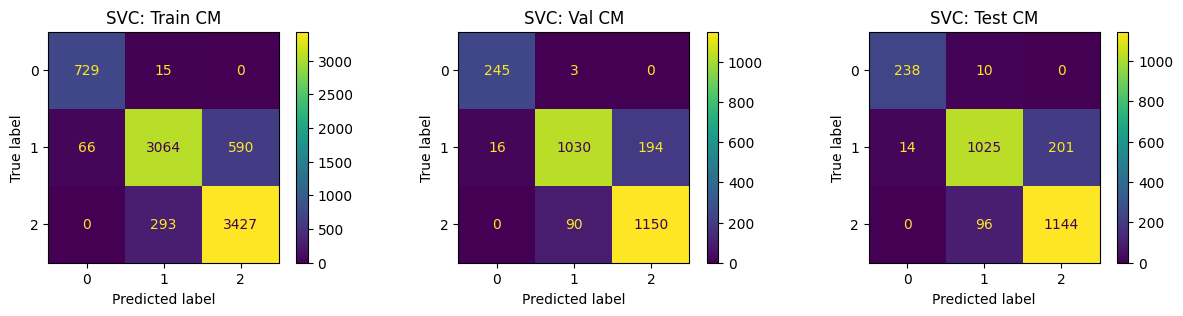

In [ ]:
cm_svc = []
cm_svc.append(confusion_matrix(y_train, linear_svm.predict(X_train_scaled), labels=linear_svm.classes_))
cm_svc.append(confusion_matrix(y_val, linear_svm.predict(X_val_scaled), labels=linear_svm.classes_))
cm_svc.append(confusion_matrix(y_test, linear_svm.predict(X_test_scaled), labels=linear_svm.classes_))

fig, axes = plt.subplots(1, 3, figsize=(15, 3))
title_ = ['SVC: Train CM', 'SVC: Val CM', 'SVC: Test CM']
for i in range(len(axes)):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc[i])
    disp.plot(ax=axes[i])
    axes[i].set_title(title_[i])

#### **3.2.4 Strengths and Weakness of Linear Models**

**Parameters**: The main parameter in linear models is the regularization term. Model performance can vary based on the type of regularization used (i.e., L-1 or L-2).

**Strengths:**
1. Faster Training
2. Scalable
3. Explainable using weights

**Weakness:**
1. Difficult to understand the results if features are correlated.
2. Often works when number of features is large compared to number of samples.

**KEY NOTE**
- The performance of the linear models can be improved using the kernel trick where we add nonlinear features to our feature set using polynomial kernel and radius basis function (Gaussian Kernal).

Gaussian kernel: $k_{rbf}(x_1, x_2) = exp(γ||x_1 - x_2||^2)$ where $\gamma$ is the width of the kernel.

These method can be used to generate a complex non-linear boundary.



### **3.3 Naive Bayes Classifiers**



In [ ]:
from sklearn.naive_bayes import GaussianNB

#### **3.3.1 Gaussian Naive Bayes**

We will apply the Gaussian NB in this study as all the features are continuous.

In [ ]:
clf_NB = GaussianNB().fit(X_train_scaled, y_train)
print("Train set accuracy: {:.2f}".format(clf_NB.score(X_train_scaled, y_train)))
print("Validation set accuracy: {:.2f}".format(clf_NB.score(X_val_scaled, y_val)))
print("Test set accuracy: {:.2f}".format(clf_NB.score(X_test_scaled, y_test)))

Train set accuracy: 0.96
Validation set accuracy: 0.97
Test set accuracy: 0.96


#### **3.3.2 Analyzing Gaussian Naive Bayes**

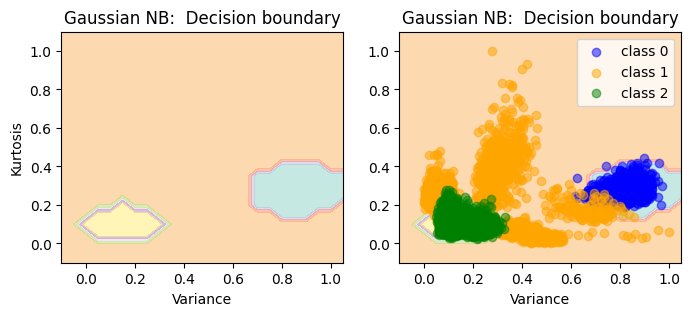

In [ ]:
ct = 0
cm, cm_v, cm_t = [], [], []
check = [0, 1]
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
for ax, i in zip(axes, check):
    if i==0:
        plot_decisions(clf_NB, X_train_scaled, y_train, ax, 'Gaussian NB: ')
    else:
        plot_decisions(clf_NB, X_train_scaled, y_train, ax, 'Gaussian NB: ', True)
    if ct==0:
        ct += 1
        ax.set_ylabel('Kurtosis')

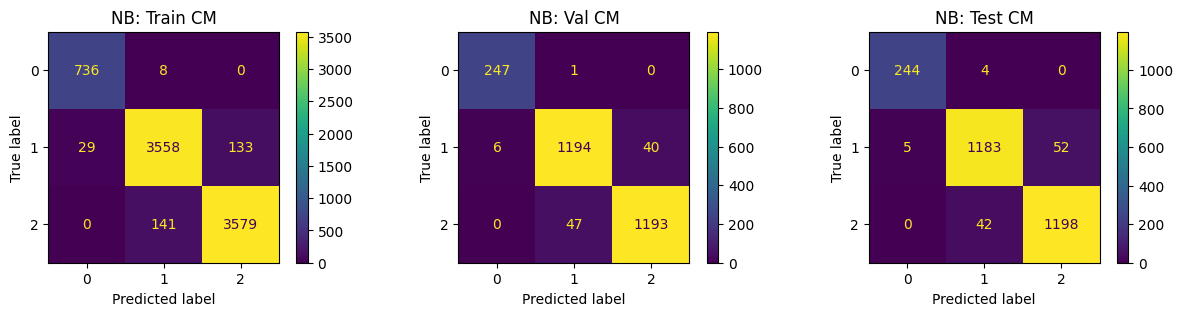

In [ ]:
cm_nb = []
cm_nb.append(confusion_matrix(y_train, clf_NB.predict(X_train_scaled), labels=clf_NB.classes_))
cm_nb.append(confusion_matrix(y_val, clf_NB.predict(X_val_scaled), labels=clf_NB.classes_))
cm_nb.append(confusion_matrix(y_test, clf_NB.predict(X_test_scaled), labels=clf_NB.classes_))

fig, axes = plt.subplots(1, 3, figsize=(15, 3))
title_ = ['NB: Train CM', 'NB: Val CM', 'NB: Test CM']
for i in range(len(axes)):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_nb[i])
    disp.plot(ax=axes[i])
    axes[i].set_title(title_[i])

#### **Strengths and Weakness of Naive Bayes Classifiers**

The three widely used naive bayes classifiers are:

*   Gaussian NB: applied to continuous data, highly dimensional data
*   Bernoulli NB: applied to binary data, sparse data
*   Multinomial NB: applied to count data, sparse data

Note: The weights in these models has a different meaning compared to what was observed in linear models.

**Strengths:**
1. Fast to train and predict like linear models
2. Easy to understand
3. Works well on highly dimensional data as well

**Weakness:**
1. Efficiency can be impacted and might not generalize well.



### **3.4 Decision Tree Classifier**


In [ ]:
from sklearn.tree import DecisionTreeClassifier

#### **3.4.1 Building Decision Trees**

In [ ]:
clf_DT = DecisionTreeClassifier(max_depth=5).fit(X_train_scaled, y_train)
print("Train set accuracy: {:.2f}".format(clf_DT.score(X_train_scaled, y_train)))
print("Validation set accuracy: {:.2f}".format(clf_DT.score(X_val_scaled, y_val)))
print("Test set accuracy: {:.2f}".format(clf_DT.score(X_test_scaled, y_test)))

Train set accuracy: 0.97
Validation set accuracy: 0.97
Test set accuracy: 0.97


#### **3.4.3 Analyzing Decision Boundaries**

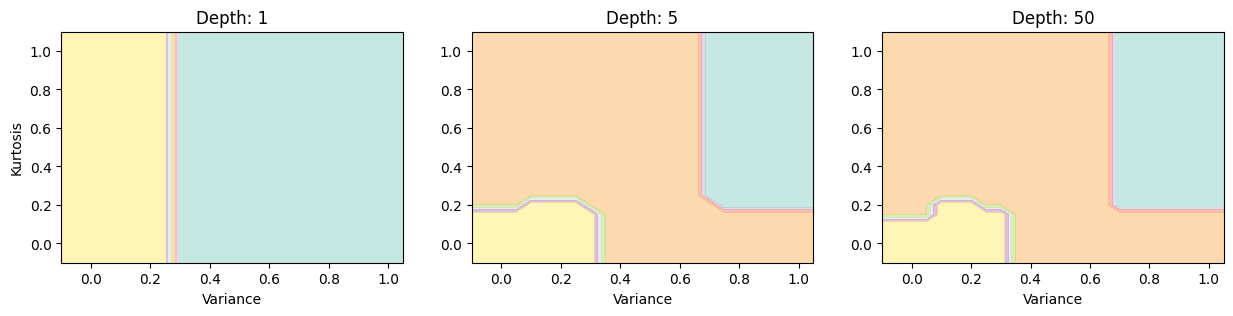

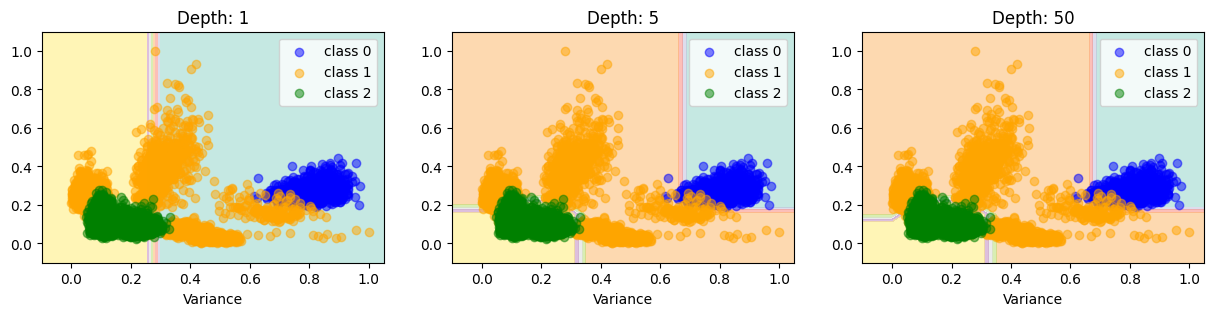

In [ ]:
ct = 0
cm, cm_v, cm_t = [], [], []
ns = [1, 5, 50]

fig, axes = plt.subplots(1, 3, figsize=(15, 3))
for n, ax in zip(ns, axes):
    clf = DecisionTreeClassifier(max_depth=n).fit(X_train_scaled, y_train)
    plot_decisions_multiple(clf, X_train_scaled, y_train, ax, n, title='Depth: {}'.format(n))
    if ct==0:
        ct += 1
        ax.set_ylabel('Kurtosis')
    cm.append(confusion_matrix(y_train, clf.predict(X_train_scaled), labels=clf.classes_))
    cm_v.append(confusion_matrix(y_val, clf.predict(X_val_scaled), labels=clf.classes_))
    cm_t.append(confusion_matrix(y_test, clf.predict(X_test_scaled), labels=clf.classes_))


fig1, axes1 = plt.subplots(1, 3, figsize=(15, 3))
for n, ax in zip(ns, axes1):
    clf = DecisionTreeClassifier(max_depth=n).fit(X_train_scaled, y_train)
    plot_decisions_multiple(clf, X_train_scaled, y_train, ax, n, 'Depth: {}'.format(n), True)
    if ct==0:
        ct += 1
        ax.set_ylabel('Kurtosis')


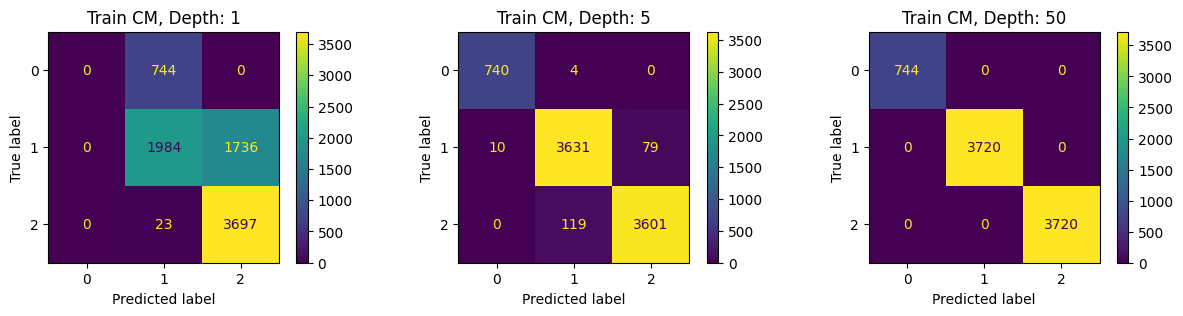

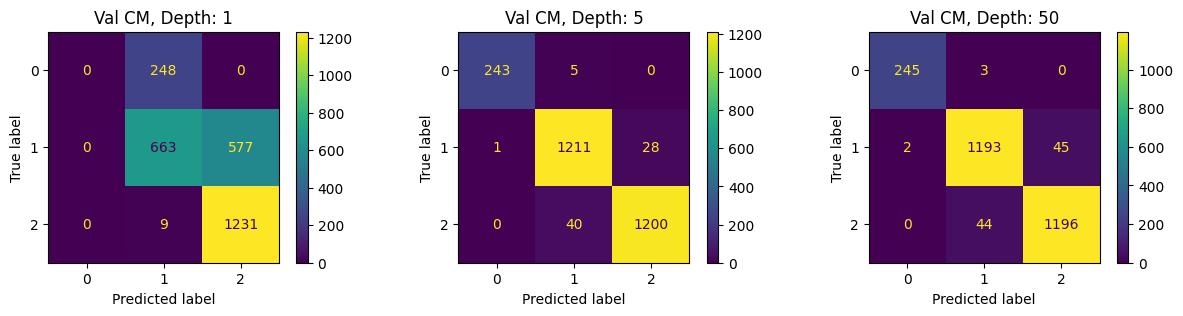

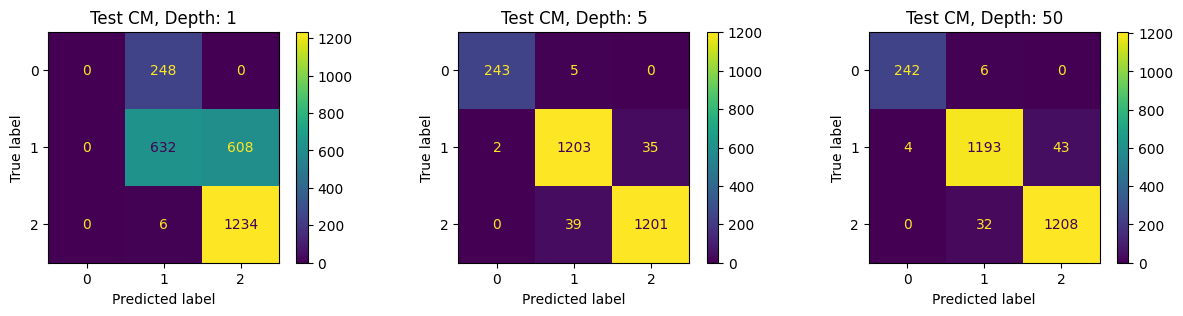

In [ ]:

fig2, axes2 = plt.subplots(1, 3, figsize=(15, 3))
for i in range(len(axes2)):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm[i])
    disp.plot(ax=axes2[i])
    axes2[i].set_title('Train CM, Depth: {}'.format(ns[i]))

fig3, axes3 = plt.subplots(1, 3, figsize=(15, 3))
for i in range(len(axes2)):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_v[i])
    disp.plot(ax=axes3[i])
    axes3[i].set_title('Val CM, Depth: {}'.format(ns[i]))

fig4, axes4 = plt.subplots(1, 3, figsize=(15, 3))
for i in range(len(axes2)):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_t[i])
    disp.plot(ax=axes4[i])
    axes4[i].set_title('Test CM, Depth: {}'.format(ns[i]))


#### **3.4.4 Strengths and Weakness**

There are several parameters that could be explored to understand how the model performs under their variations. For this study, we will focus on the depth of the tree.

We saw on the decision boundary plots that as depth increase, so does the decision boundaries' complexities. Also, on the confusion matrix it was clear that the for higher depth the train set performance is extremely good but a similar performance is not seen in the test set. Pruning is often employed to control the complexity where the nodes are removed if they are not significant.

**Weakness:**
1. Prone to overfiting
2. Poor generalization (ensemble is the way to go)

**Advantages:**
1. Easy visualization
2. Scaling is not required